In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#importing libraries
import numpy as np 

%matplotlib inline 
#to use as command line calls #using inline graphs will come next to code

import matplotlib.pyplot as plt #for graphs
import os #for operating system dependent fucntionality
from keras import layers #for building layers of neural net
from keras.models import Model
from keras.models import load_model
from keras import callbacks #for training logs, saving to disk periodically
import cv2 #OpenCV(Open Source computer vision lib), containg CV algos
import string

Using TensorFlow backend.


In [3]:
#print images in dataset
os.listdir("/content/drive/My Drive/captcha_dataset/samples")

['8gmc4.png',
 '8d8ep.png',
 '8n34n.png',
 '8n65n.png',
 '8n4n8.png',
 '8np22.png',
 '8nbew.png',
 '8wy7d.png',
 '8xef7.png',
 '8y63f.png',
 '8ypdn.png',
 '23mdg.png',
 '25m6p.png',
 '32cnn.png',
 '25egp.png',
 '36nx4.png',
 '34b84.png',
 '37d52.png',
 '42dw4.png',
 '47m2b.png',
 '42xpy.png',
 '53mn8.png',
 '56c34.png',
 '55y2m.png',
 '65ebm.png',
 '64m82.png',
 '62nb3.png',
 '85dxn.png',
 '243mm.png',
 '75pfw.png',
 '244e2.png',
 '268g2.png',
 '245y5.png',
 '474ff.png',
 '428b6.png',
 '865wm.png',
 '658xe.png',
 '832f3.png',
 '7634y.png',
 '4433m.png',
 '52447.png',
 'b5fm7.png',
 'b55d6.png',
 'b28g8.png',
 '76353.png',
 'bmxpe.png',
 'bdg84.png',
 'b685n.png',
 'bn5mw.png',
 'bnc2f.png',
 'bw44w.png',
 'c4bny.png',
 'c2yn8.png',
 'byc82.png',
 'c4mcm.png',
 'c8n8c.png',
 'c7gb3.png',
 'c7nn8.png',
 'c55c6.png',
 'c4527.png',
 'cdfen.png',
 'cd4eg.png',
 'cb8cf.png',
 'cfw6e.png',
 'cfp86.png',
 'cnex4.png',
 'cnwyc.png',
 'd7en3.png',
 'd3c8y.png',
 'd22y5.png',
 'd66cn.png',
 'd22b

In [4]:
#total no of images in dataset
n=len(os.listdir("/content/drive/My Drive/captcha_dataset/samples"))
n

1070

In [5]:
#defining size of image
imgshape=(50,200,1) #50-height, 200-width, 1-no of channels

In [6]:
character= string.ascii_lowercase + "0123456789" # All symbols captcha can contain
nchar = len(character) #total number of char possible
nchar

36

In [7]:
#preprocesss image
def preprocess():
  X = np.zeros((n,50,200,1)) #1070*50*200 array with all entries 0
  y = np.zeros((5,n,nchar)) #5*1070*36(5 letters in captcha) with all entries 0

  for i, pic in enumerate(os.listdir("/content/drive/My Drive/captcha_dataset/samples")):
  #i represents index no. of image in directory 
  #pic contains the file name of the particular image to be preprocessed at a time
    
    img = cv2.imread(os.path.join("/content/drive/My Drive/captcha_dataset/samples", pic), cv2.IMREAD_GRAYSCALE) #Read image in grayscale format
    pic_target = pic[:-4]#this drops the .png extension from file name and contains only the captcha for training
    
    if len(pic_target) < 6: #captcha is not more than 5 letters
      img = img / 255.0 #scales the image between 0 and 1
      img = np.reshape(img, (50, 200, 1)) #reshapes image to width 200 , height 50 ,channel 1 

      target=np.zeros((5,nchar)) #creates an array of size 5*36 with all entries 0

      for j, k in enumerate(pic_target):
      #j iterates from 0 to 4(5 letters in captcha)
      #k denotes the letter in captcha which is to be scanned
         index = character.find(k) #index stores the position of letter k of captcha in the character string
         target[j, index] = 1 #replaces 0 with 1 in the target array at the position of the letter in captcha

      X[i] = img #stores all the images
      y[:,i] = target #stores all the info about the letters in captcha of all images

  return X,y

In [8]:
#create model
def createmodel():
    img = layers.Input(shape=imgshape) # Get image as an input of size 50,200,1
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img) #50*200
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 25*100
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 13*50
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3) #to improve the stability of model
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 7*25
    
    flat = layers.Flatten()(mp3) #convert the layer into 1-D

    outs = []
    for _ in range(5): #for 5 letters of captcha
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1) #drops 0.5 fraction of nodes
        res = layers.Dense(nchar, activation='sigmoid')(drop)

        outs.append(res) #result of layers
    
    # Compile model and return it
    model = Model(img, outs) #create model
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [9]:
#Create model
model=createmodel();
model.summary();

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 200, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 200, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 25, 100, 16)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 25, 100, 32)  4640        max_pooling2d_1[0][0]            
____________________________________________________________________________________________

In [10]:
X,y=preprocess()

In [11]:
#split the 1070 samples where 970 samples will be used for training purpose
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]

In [12]:
#Applying the model
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=60, validation_split=0.2)
#batch size- 32 defines no. of samples per gradient update
#Validation split=0.2 splits the training set in 80-20% for training nd testing

Train on 776 samples, validate on 194 samples
Epoch 1/60
776/776 [==============================] - 9s 11ms/step - loss: 17.5380 - dense_2_loss: 3.4880 - dense_4_loss: 3.4714 - dense_6_loss: 3.4592 - dense_8_loss: 3.5163 - dense_10_loss: 3.5724 - dense_2_accuracy: 0.0503 - dense_4_accuracy: 0.0490 - dense_6_accuracy: 0.0554 - dense_8_accuracy: 0.0490 - dense_10_accuracy: 0.0451 - val_loss: 17.3565 - val_dense_2_loss: 3.4693 - val_dense_4_loss: 3.4237 - val_dense_6_loss: 3.4535 - val_dense_8_loss: 3.4672 - val_dense_10_loss: 3.5089 - val_dense_2_accuracy: 0.0722 - val_dense_4_accuracy: 0.0155 - val_dense_6_accuracy: 0.0361 - val_dense_8_accuracy: 0.0567 - val_dense_10_accuracy: 0.0670
Epoch 2/60
776/776 [==============================] - 7s 9ms/step - loss: 16.2657 - dense_2_loss: 3.2682 - dense_4_loss: 3.2070 - dense_6_loss: 3.1535 - dense_8_loss: 3.2923 - dense_10_loss: 3.3273 - dense_2_accuracy: 0.0503 - dense_4_accuracy: 0.0670 - dense_6_accuracy: 0.0722 - dense_8_accuracy: 0.0515 -

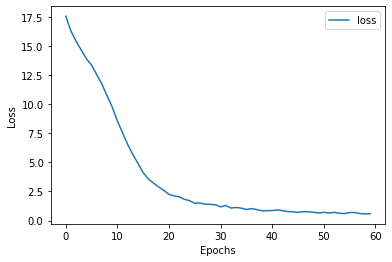

In [13]:
#graph of loss vs epochs
for label in ["loss"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

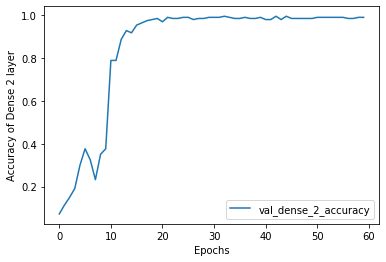

In [14]:
#graph of accuracy of dense_2 vs epochs
for label in ["val_dense_2_accuracy"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy of Dense 2 layer")
plt.show()

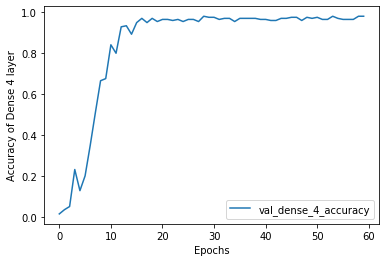

In [15]:
#graph of accuracy of dense_4 vs epochs
for label in ["val_dense_4_accuracy"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy of Dense 4 layer")
plt.show()

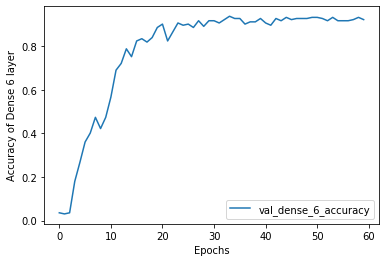

In [16]:
#graph of accuracy of dense_6 vs epochs
for label in ["val_dense_6_accuracy"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy of Dense 6 layer")
plt.show()

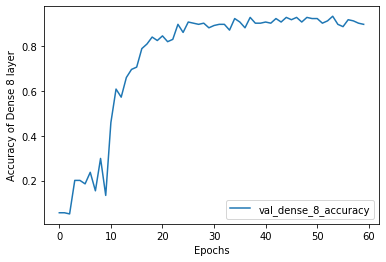

In [17]:
#graph of accuracy of dense_8 vs epochs
for label in ["val_dense_8_accuracy"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy of Dense 8 layer")
plt.show()

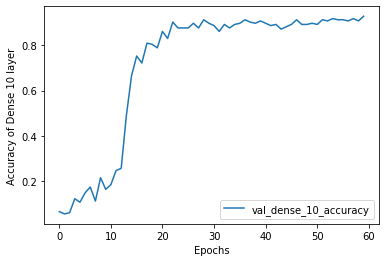

In [18]:
#graph of accuracy of dense_10 vs epochs
for label in ["val_dense_10_accuracy"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy of Dense 10 layer")
plt.show()

In [19]:
#Loss on training set
#Finding Loss on training set
preds = model.evaluate(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]])
print ("Loss on training set= " + str(preds[0]))

970/970 [==============================] - 3s 3ms/step
Loss on training set= 0.23914067802816322


In [20]:
#Finding loss on test set
preds = model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print ("Loss on testing set= " + str(preds[0]))

100/100 [==============================] - 0s 3ms/step
Loss on testing set= 2.1232204596325754


In [21]:
#to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    if img is not None: #image foud at file path
        img = img / 255.0 #Scale image
    else:
        print("Not detected");

    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis])) #np.newaxis=1 
    #added this bcoz x_train 970*50*200*1
    #returns array of size 1*5*36 
    result = np.reshape(res, (5, 36)) #reshape the array
    k_ind = []
    probs = []
    for i in result:
        k_ind.append(np.argmax(i)) #adds the index of the char found in captcha

    capt = '' #string to store predicted captcha
    for k in k_ind:
        capt += character[k] #finds the char corresponding to the index
    return capt 

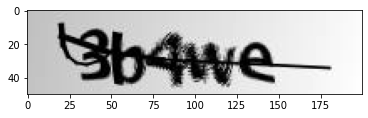

In [22]:
#Check model on samples
img=cv2.imread('/content/drive/My Drive/mnop2.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))


In [23]:
print("Predicted Captcha =",predict('/content/drive/My Drive/mnop2.png'))

Predicted Captcha = 3b4we


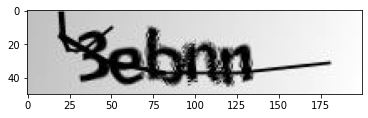

In [24]:
#Sample 2
img=cv2.imread('/content/drive/My Drive/34d.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [25]:
print("Predicted Captcha =",predict('/content/drive/My Drive/34d.png'))

Predicted Captcha = 3ebnn
